# Filtering Foursquare Data

In this notebook we process a full data set with Foursquare venues and check-ins. It's [available here](https://sites.google.com/site/yangdingqi/home/foursquare-dataset). We keep only the venues and check-ins within our areas of interest defined in the previous notebook.

## Preamble

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(context='notebook', font='Lucida Sans Unicode', style='white', palette='plasma')

In [3]:
import pandas as pd
import geopandas as gpd

We use `dask.dataframe` to process huge text files.

In [53]:
import dask.dataframe as dd

Here we load the results of the previous notebook.

In [4]:
areas = gpd.read_file('output/santiago_relevant_area.geo.json')

In [5]:
grid = gpd.read_file('output/santiago_relevant_grid.geo.json')

In [6]:
bbox = areas.total_bounds
bbox

array([-70.9678545, -33.7540753, -70.1758683, -33.0969351])

## Venue Processing

Here we analyze venues (or Points of Interest). 

In [9]:
import pyarrow
print(pyarrow.__version__)
pois = pd.read_csv('4sq_2019/raw_POIs.txt', sep='\t', names=['venue_id', 'lat', 'lon', 'category', 'country']) # dd.read_csv is not working with the current version of pyarrow

19.0.0


In [10]:
pois.head()

,venue_id,lat,lon,category,country
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US


In [11]:
pois_in_bbox = pois[pois.lon.between(bbox[0], bbox[2]) & pois.lat.between(bbox[1], bbox[3])]
pois_in_bbox.sample(5)

,venue_id,lat,lon,category,country
3715714,4df26725c65bf55ee527d33b,-33.432147,-70.640753,Restaurant,CL
9693848,512f44b4e4b0a1e8e1aed4a3,-33.423949,-70.610825,Coworking Space,CL
7263026,4fd4ee3ae4b0d45a95f56d66,-33.442537,-70.663317,Home (private),CL
2772781,4d3af5da49cb236aa833bf47,-33.433475,-70.651035,Seafood Restaurant,CL
9457772,510a87c9e4b0b12f39488007,-33.455055,-70.690239,Moving Target,CL


In [12]:
len(pois_in_bbox)

95670

Text(0.5, 0, '# of Venues (POIs)')

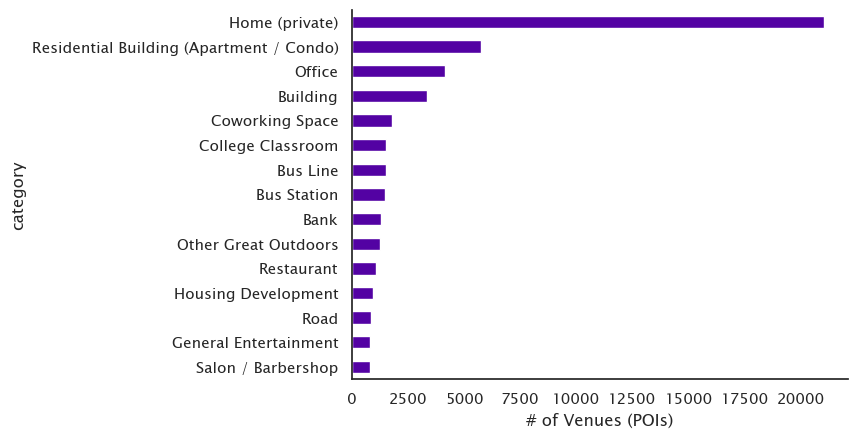

In [61]:
ax = pois_in_bbox.category.value_counts().head(15).sort_values().plot(kind='barh')
sns.despine(ax=ax)
ax.set_xlabel('# of Venues (POIs)')

<Axes: >

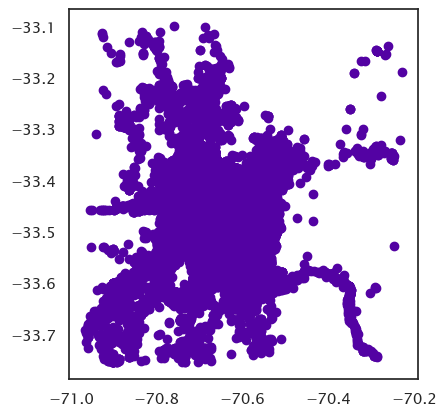

In [13]:
pois_gdf = gpd.GeoDataFrame(pois_in_bbox[['venue_id', 'category']],
                            geometry=gpd.points_from_xy(pois_in_bbox.lon, pois_in_bbox.lat),
                            crs=areas.crs)
pois_gdf.plot()

In [14]:
pois_gdf_amb = gpd.sjoin(pois_gdf, grid[['geometry',]], predicate='within', how='inner')
pois_gdf_amb

,venue_id,category,geometry,index_right
109597,4af8ffeaf964a520cd1022e3,Other Great Outdoors,POINT (-70.66046 -33.44616),1135
222118,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),3752
222118,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),3753
222614,4b44abe7f964a5201ef925e3,Sushi Restaurant,POINT (-70.57765 -33.41222),2411
222624,4b44ad89f964a52040f925e3,Office,POINT (-70.57276 -33.40448),2939
...,...,...,...,...
11179377,52e8241811d24e40d89978d0,Home (private),POINT (-70.60383 -33.47606),3846
11179605,52e8d7ad498e459461a0b33b,Bus Line,POINT (-70.72786 -33.42376),4604
11179962,52e90de1498ed1ed01b47aaf,Bus Line,POINT (-70.84306 -33.44869),4040
11179993,52e912e9498ed5442c097af5,Campaign Office,POINT (-70.61707 -33.39269),2354


<Axes: >

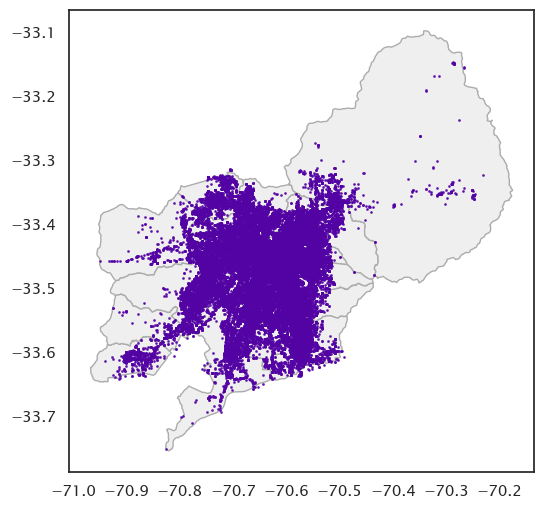

In [64]:
ax = areas.plot(figsize=(16, 6), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
pois_gdf_amb.plot(ax=ax, markersize=1, alpha=0.8)

In [15]:
pois_grid = gpd.sjoin(pois_gdf, grid[['geometry',]], predicate='within', how='inner')


In [16]:
pois_grid.head()

,venue_id,category,geometry,index_right
109597,4af8ffeaf964a520cd1022e3,Other Great Outdoors,POINT (-70.66046 -33.44616),1135
222118,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),3752
222118,4b4463faf964a52078f425e3,Sushi Restaurant,POINT (-70.51793 -33.3738),3753
222614,4b44abe7f964a5201ef925e3,Sushi Restaurant,POINT (-70.57765 -33.41222),2411
222624,4b44ad89f964a52040f925e3,Office,POINT (-70.57276 -33.40448),2939


In [17]:
grid_n_pois = pois_grid.groupby('index_right').size()
grid_n_pois.name = 'poi_count'

c:\Users\sebam\miniconda3\envs\multisource-flows\Lib\site-packages\geopandas\plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


Text(0.5, 1.0, '# of POIs in the Santiago Metropolitan Area (Foursquare data)')

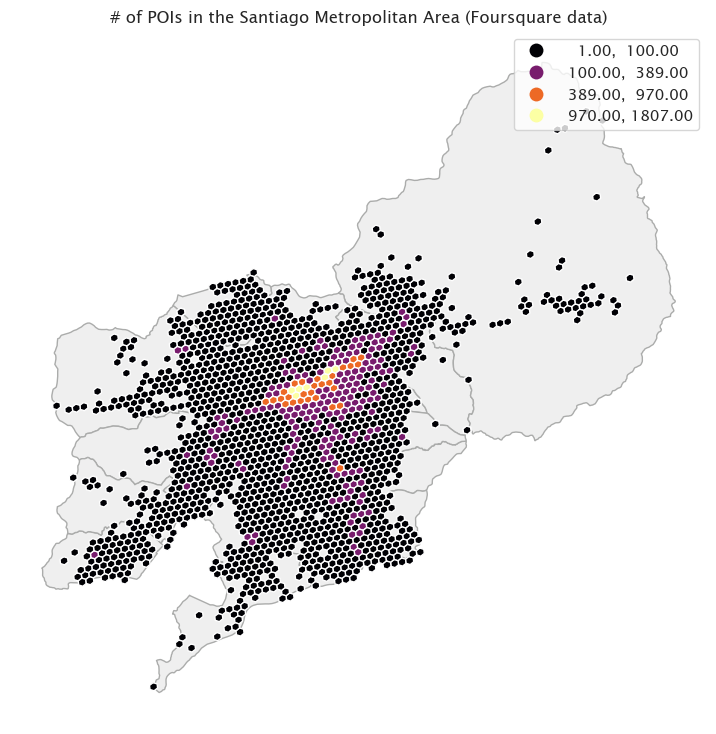

In [18]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(grid_n_pois).dropna().plot(column='poi_count', cmap='inferno', k=4, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('# of POIs in the Santiago Metropolitan Area (Foursquare data)')

## Check-Ins

In [7]:
check_ins = pd.read_csv('4sq_2019/raw_Checkins_anonymized.txt', sep='\t', names=['user_id', 'venue_id', 'datetime', 'utc_offset']) # dd.read_csv is not working with the current version of pyarrow
check_ins.head()

,user_id,venue_id,datetime,utc_offset
0,546830,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,2277773,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,1139878,4d9254ef62ad5481fa6e6a4b,Tue Apr 03 18:00:08 +0000 2012,-180


In [19]:
amb_check_ins = check_ins[check_ins.venue_id.isin(pois_gdf_amb.venue_id)]
amb_check_ins.shape

(1307956, 4)

In [20]:
amb_check_ins.head()

,user_id,venue_id,datetime,utc_offset
56,44093,4dc0367c6a23e5a549e68d9b,Tue Apr 03 18:00:22 +0000 2012,-180
82,980044,4bb8ddd31261d13ab608e998,Tue Apr 03 18:00:27 +0000 2012,-180
83,640995,4f7200c9e4b0e30fde677e23,Tue Apr 03 18:00:28 +0000 2012,-180
179,969261,4d386aa93ffba1433b405c56,Tue Apr 03 18:00:55 +0000 2012,-180
180,1424666,4b6f2cf8f964a52013e22ce3,Tue Apr 03 18:00:55 +0000 2012,-180


In [21]:
user_counts = amb_check_ins.user_id.value_counts()
user_counts.describe()

count    41112.000000
mean        31.814458
std         73.399565
min          1.000000
25%          2.000000
50%          8.000000
75%         29.000000
max       2943.000000
Name: count, dtype: float64

In [22]:
venue_counts = amb_check_ins.venue_id.value_counts()
venue_counts.name = 'popularity'
venue_counts.describe()

count    92231.000000
mean        14.181306
std        100.113770
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max      17293.000000
Name: popularity, dtype: float64

In [23]:
venues = pois_gdf_amb.join(venue_counts, on='venue_id').dropna()
venues.shape, pois_gdf_amb.shape

((127363, 5), (127363, 4))

In [24]:
venues.groupby('index_right')['popularity'].sum()

index_right
0        159
2        611
3         31
4          2
6        124
        ... 
4611      76
4614    2281
4615     208
4618      13
4619       2
Name: popularity, Length: 2047, dtype: int64

In [25]:
top_popular = venues.sort_values('popularity', ascending=False).head(15)#.to_text()

Text(0.5, 0, 'Popularity')

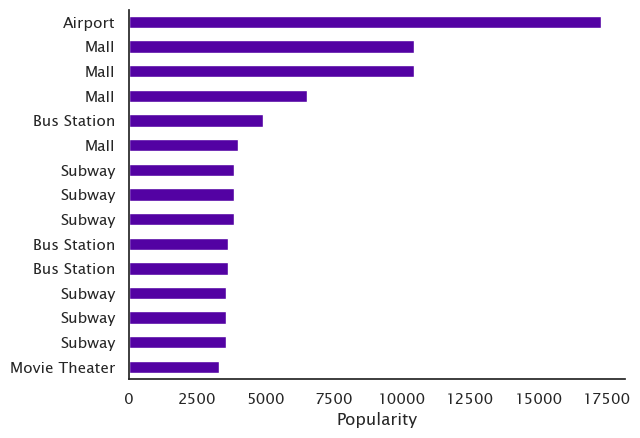

In [26]:
ax = top_popular[['category', 'popularity']].set_index('category').popularity.sort_values(ascending=True).plot(kind='barh', legend=False)
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Popularity')

c:\Users\sebam\miniconda3\envs\multisource-flows\Lib\site-packages\geopandas\plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


Text(0.5, 1.0, 'Popularity of Cells in the Santiago Metropolitan Area (Foursquare data)')

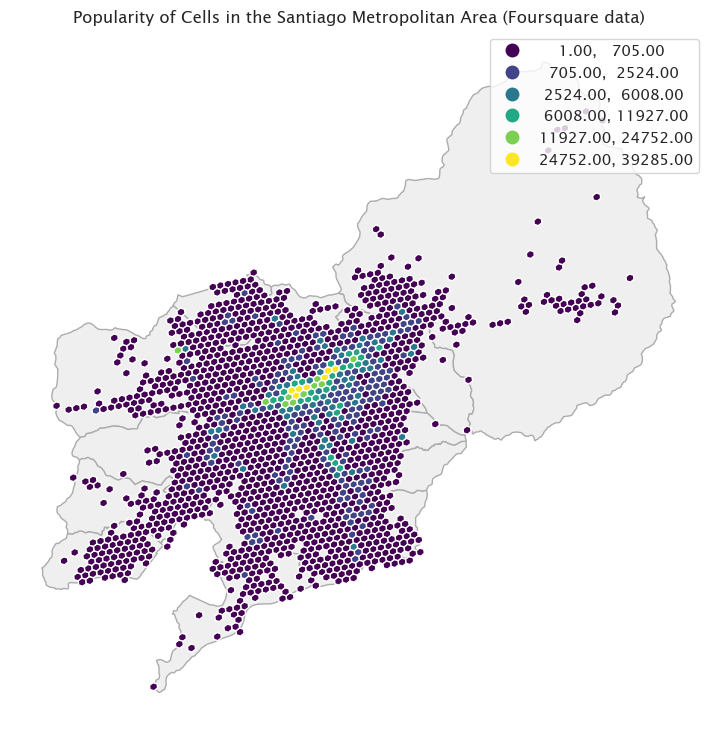

In [27]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(venues.groupby('index_right')['popularity'].sum()).dropna().plot(column='popularity', k=6, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('Popularity of Cells in the Santiago Metropolitan Area (Foursquare data)')

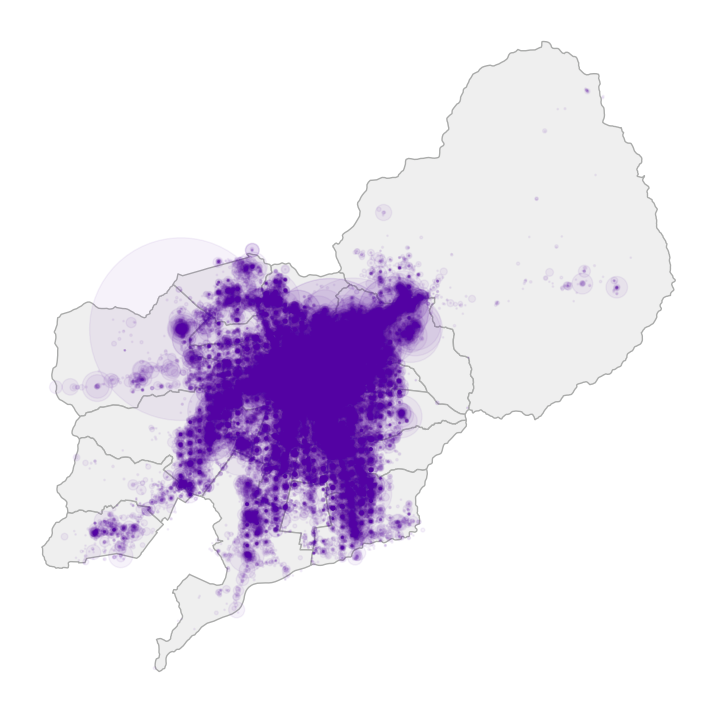

In [28]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
venues.plot(ax=ax, alpha=0.05, markersize='popularity')
ax.set_axis_off()

## Data Export

Here we save the relevant information, i.e., venues and check-ins in the areas of interest.

In [29]:
amb_check_ins.to_csv('output/santiago_relevant_check_ins.csv.gz')

In [30]:
pois_grid.to_file('output/santiago_relevant_pois.json', driver='GeoJSON')